# VOC2012 Data Prep

## Import module and download data

In [1]:
import numpy as np
import tensorflow as tf
import random 
import os
from tqdm import trange
from PIL import Image , ImageOps
import matplotlib.pyplot as plt

## Get VOC2012

Run commented out terminal commands below to download data if needed.

In [2]:
#!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
#!tar xopf VOCtrainval_11-May-2012.tar

## Helper functions for loading images and mask

In [3]:
voc_dir = 'VOCdevkit/VOC2012'

In [4]:
def read_voc_images(voc_dir,crop_size=(320, 224),is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        img = Image.open(os.path.join(voc_dir, 'JPEGImages', f'{fname}.jpg'))
        w, h = img.size
        lr = random.randint(0, max(w-crop_size[0],0))
        up = random.randint(0, max(h-crop_size[1],0))
        img = img.crop((lr, up, lr+crop_size[0], up+crop_size[1])) 
        features.append(np.transpose(np.array(img), (1,0,2)))
        
        mask = Image.open(os.path.join(voc_dir, 'SegmentationClass', f'{fname}.png'))
        mask = mask.convert('RGB')
        mask= mask.crop((lr, up, lr+crop_size[0], up+crop_size[1])) 
        labels.append(np.transpose(np.array(mask), (1,0,2)))
    return features, labels

# crop_size = (height,width)
train_features, train_labels = read_voc_images(voc_dir,crop_size=(320, 224), is_train=True)

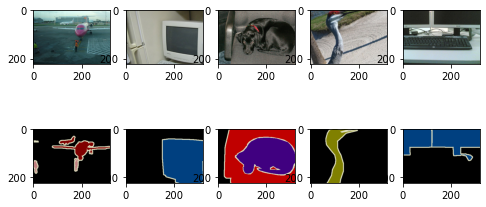

In [5]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]

columns = 5
rows = 2
fig=plt.figure(figsize=(8, 4))

for i in range(1, columns*rows +1):
    img = np.array(imgs[i-1])[:,:]
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.transpose(np.array(img), (1,0,2)))
plt.show()

In [6]:
print(train_features[0].shape)
print(train_labels[0].shape)

(320, 224, 3)
(320, 224, 3)


In [7]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

N_CLASSES = 21

There are 21 classes

In [8]:
def build_colormap2label():
    """Build an RGB color to label mapping for segmentation."""
    colormap2label = np.zeros(256 ** 3)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0]*256 + colormap[1])*256 + colormap[2]] = i
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    """Map an RGB color to a label."""
    colormap = colormap.astype(np.int32)
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

def getMask(y):
    b = np.zeros((y.shape[0],y.shape[1]))
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            val = int(y[i,j])
            b[i,j] = val
    b = b.astype('uint8')
    return b

In [9]:
# Test target value making procedure
y = voc_label_indices(train_labels[4], build_colormap2label())
mask_y = getMask(y)
print(mask_y.shape)
print(np.unique(mask_y))

(320, 224)
[ 0 20]


## Make tfRecords
Nice example: https://gist.github.com/yinguobing/3b24c1c4ba0a792a7866c8197818c4f5

In [10]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [11]:
def make_img_tfRecord(X,y):
    feature = {
        'rows': _int64_feature(X.shape[0]),
        'cols': _int64_feature(X.shape[1]),
        'depth': _int64_feature(X.shape[2]),
        'image': _bytes_feature(X.tobytes()),
        'target': _bytes_feature(y.tobytes()),
        }
    
    return tf.train.Example(features=tf.train.Features(feature=feature))

### Write to record train

In [12]:
record_file = 'tfData/train_record.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
    for i in trange(len(train_features)):
        mask = voc_label_indices(train_labels[i], build_colormap2label())
        mask = getMask(mask)
        tf_example = make_img_tfRecord(train_features[i],mask)
        writer.write(tf_example.SerializeToString())

100%|██████████| 1464/1464 [01:18<00:00, 18.71it/s]


### Write to record val

In [13]:
val_features, val_labels = read_voc_images(voc_dir,crop_size=(320, 224), is_train=False)

record_file = 'tfData/val_record.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
    for i in trange(len(val_features)):
        mask = voc_label_indices(val_labels[i], build_colormap2label())
        mask = getMask(mask)
        tf_example = make_img_tfRecord(val_features[i],mask)
        writer.write(tf_example.SerializeToString())

100%|██████████| 1449/1449 [01:20<00:00, 17.96it/s]


## Check record

In [14]:
dataset = tf.data.TFRecordDataset(record_file, buffer_size=100)

In [15]:
# Decoding function
def parse_record(record):
    name_to_features = {
        'rows': tf.io.FixedLenFeature([], tf.int64),
        'cols': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(record, name_to_features)

def decode_record(record):
    image = tf.io.decode_raw(
        record['image'], out_type='uint8', little_endian=True, fixed_length=None, name=None
    )
    target = tf.io.decode_raw(
        record['target'], out_type='uint8', little_endian=True, fixed_length=None, name=None
    )
        
    rows = record['rows']
    cols = record['cols']
    depth = record['depth']

    image = tf.reshape(image, (rows,cols,depth))
    target = tf.reshape(target, (rows,cols))
    
    return (image,target)

In [16]:
images, labels = [], []
for record in dataset:
    parsed_record = parse_record(record)
    decoded_record = decode_record(parsed_record)
    img, label = decoded_record
    images.append(img)
    labels.append(label)

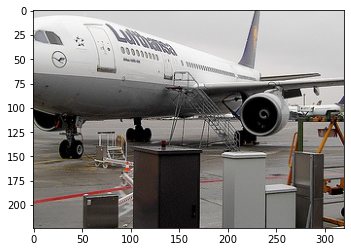

In [17]:
img = images[0].numpy()
img = Image.fromarray(img,'RGB')
imgplot = plt.imshow(np.transpose(np.array(img), (1,0,2)))
plt.show()

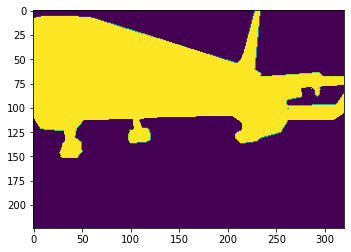

In [18]:
outline = labels[0].numpy()
outline = Image.fromarray(outline)
imgplot = plt.imshow(np.transpose(np.array(outline), (1,0)))
plt.show()

Ey looking good!